<h2><b>Heisenberg Model: Qubitized Dynamics</b></h2>
<font size="3">

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
<hr><hr>
</font>

<h3><u>1. Overview</u></h3>

This notebook demonstrates how `pyLIQTR` can assemble qubitized simulations of Heisenberg-type spin models (via QSP/QET/QSVT).  While our target is a two-dimensional square lattice, this framework extends to arbitrary symmetries and dimensionality (see the general spin models exmple).  It is important to note that a realistic workflow requires components for state preparation and analysis steps, such as the calculation of correlation functions.  These tasks are demonstrated in a separate notebook.

<hr></hr>

<h3><u>2. Background</u></h3>

This example addresses the Heisenberg model on an arbitrary 2d or 3d lattice:

\begin{equation}
H =   \sum_{\mu, \langle p, q \rangle} J^\mu_{p,q}\, (\sigma^\mu_{p} \otimes \sigma^\mu_{q}) + \sum_{\mu, p} h^{\mu}_{p} \, \sigma^\mu_{p}.
\end{equation}

We label lattice sites with composite indices $p,q$ and use angle brackets denote summation over spatially nearest-neighbor pairs. The index $\mu \in \{x,y,z\}$ specifies the Pauli operators $\sigma^\mu$, which we define according to the "physicist's convention." The first term in this Hamiltonian gives a bilinear spin-spin coupling of strength $J^\mu_{p,q}$ and the second specifies local fields of magnitude $ h^{\mu}_{p}$. 

This model is two- or three-dimensional, though our qubit registers are often specified as a one-dimensional array.  Fortunately, it is a simple matter to rephrase a higher-dimensional Hamiltonian as a one-dimensional system with long-range spin couplings (e.g., by mapping the composite indices to register indices).  We accomplish this by defining a one-dimensional  path that snakes through the lattice:

<figure>
<center><img src = "./figures/heis_2d_mapping.png" width=900></center>
</figure>

This provides nearest-neighbor interactions within a row and longer-range, fixed-distance (specifically $N-1$), couplings down the columns of the lattice.  When recast in this manner the Hamiltonian becomes:

\begin{equation}
H = \sum_{\mu \in \{x,y,z\}} H_\mu,
\end{equation}

with the constituent terms,

\begin{equation}
H_\mu =  \sum_{k=1}^{N(M-1)} J^\mu \sigma^\mu_k \otimes \sigma^\mu_{k+N} + \sum_{j=0}^{M-1} \sum_{k=1}^{N-1} J^\mu \sigma^\mu_{j N + k} \otimes \sigma^\mu_{j N + k + 1} + \sum_{k=1}^{N M} h^\mu \sigma^\mu_k.
\end{equation}

The same approach extends directly to 3d.  In this case we define a zigzag path through each 2d slice and assocaite the endpoint of this path in one slice with the beginning of a path through the next.




<hr>

<h3><u>3. Simulation Methods</u></h3>

Our previous notebook introduced the Heisenberg model in terms of qubits.   We do not repeat those details, but instead focus on aspects of quantum simulation.  More specifically, our objective to construct the unitary time-evolution operator $U(t)$ using qubitized methods.

Stated generally, quantum dynamics refers to the parametric evolution of a wavefunction $|\psi(t = 0)\rangle$ under the action of a time-evolution operator | $\psi(t) \rangle = U(t,t_0) |\psi(0)\rangle$.  We will  assume that this propagation  is both unitary and time-independent $U(t,t_0) = U(t - t_0)$, though these are not general requirements (e. g., when dealing with driven / open quantum systems).  We also assume that this evolution is generated by the action of a Hamiltonian $H$ via the exponential map $U(t-t_0) = \exp[\imath H \cdot (t-t_0)]$.  Our objective is to reproduce these dynamics using some quantum circuit.  For notational simplicity we will set $t_0 = 0$.


<h5><b>Quantum Signal Processing (QSP/QET/QSVT)</b></h5>

Quantum signal processing $^*$ (QSP) and its relatives offer a resource-efficient approach  to quantum dynamics.  Stated briefly, this  framework evaluates degree-$d$ polynomial functions $P(\Lambda), Q(\Lambda)$ of a block encoded operator $\Lambda$ using a set of $d+1$ <i>classically defined</i> rotations of a phase qubit:

\begin{equation}
\mathcal{O}_{\vec{\phi}} = Z_{\Pi,\phi_0} \prod_{k=1}^d U_\Lambda Z_{\Pi,\phi_k}  =\begin{pmatrix} P(\Lambda) & Q(\Lambda) \\ Q^\dagger(\Lambda) & P(\Lambda) \end{pmatrix}.
\end{equation}

Here $U_\Lambda$ is a block encoding unitary and  $Z_{\Pi,\phi_k}$ is a qubitized phase shift operator.  The latter is essentially a multi-qubit controlled rotation, reducing to $\exp[{\imath \phi_k Z}]$ for a single-qubit encoding.  This sequence immediately translates to a quantum circuit:

 <center><img src="./figures/qsvt_sequence.png" width=1100></img></center>

where $\text{C}_\Pi\text{NOT}$ is a controlled projection and the phase shift $\exp[{\imath \phi_k Z_\Pi}]$ will be implemented as an $R_z$ rotation.  Our block encoding appears through the unitary $R = U_\Lambda Z_\Pi$, which amounts to a $y$-rotation in the qunitized eigenspaces of $\Lambda$.  While a multi-qubit reflection operator $Z_\Pi$ formally appears in this expression, we  absorb this factor into our phase convention and take $R = U_\Lambda$.


The sequence above implements a propagator when we set $\Lambda = H$ and adopt phases so that either $P(\Lambda)$  or $P(\Lambda) + \imath Q(\Lambda)$ will  approximate $\exp[\imath \Lambda \cdot t]$ (the precise choice depends on our phase and measurement conventions).  The latter approach is used by our `fourier_response` method, though the determination of phase factors can be slow and numerically unstable when  high numerical precision is required
.  A better strategy is to decompose the evolution operator as $\exp(\imath H \cdot t) = \cos (H\cdot t) + \imath \sin(H \cdot t)$ and encode the individual components as real polynomials $P(\Lambda)$ using separate circuits.  These constituents are then  combined introducing an  ancilla:

 <center><img src="./figures/qsvt_sum_circuits.png" width=500></img></center>

This approach incurs only a minor increase in qubit count and circuit depth.  This is a fair tradeoff, since it also permits fast and robust classical algorithms for factor determinations.

$^*$ <font size="3">
 The terminology surrounding QSP can be confusing. Strictly speaking, QSP describes the transformation of a single qubit block operation / encoding.  The circuits in this notebook use a qubitized variant called the Quantum Eigenvalue Transform (QET) which - stated casually -  applies a QSP sequence to the individual eigenvalues of a normal operator (i.e., over a direct sum of qubitized eigenspaces). This is taken a step further by the Quantum Singular Value Transform (QSVT) - a generalization of the QET paradigm anything that has a singular value decomposition.  QET and QSVT only differ in terms of block encoding internals, though the practical details and common phase conventions can differ markedly from QSP.
</font>

<hr>

<h3><u>4. Quantum Algorithms</u></h3>

`pyLIQTR` provides several quantum simulation methods can be used with the Heisenberg model.  We describe these and provide a demonstration below.

In [2]:

import  numpy                  as   np
import  matplotlib.pyplot      as   plt
import  cirq_ft.infra.testing  as   cirq_test

from    scipy.optimize                         import  curve_fit
from    cirq_ft.infra.jupyter_tools            import  svg_circuit

## Circuit decomposition
##
from    pyLIQTR.utils.circuit_decomposition    import   circuit_decompose_multi      

## Problem instance & Encoding items
##
from    pyLIQTR.ProblemInstances.getInstance   import   getInstance
from    pyLIQTR.clam.lattice_definitions       import   CubicLattice, SquareLattice, TriangularLattice
from    pyLIQTR.BlockEncodings.getEncoding     import   getEncoding, VALID_ENCODINGS

## QSVT simulation items
##
# from  pyLIQTR.phase_factors.simulation       import   simulation_phases
from    pyLIQTR.qubitization.qsvt_dynamics     import   qsvt_dynamics, simulation_phases

## Resource analysis
##
from   pyLIQTR.utils.resource_analysis         import   estimate_resources

## OpenQASM Export
##
from   pyLIQTR.utils.printing                  import openqasm

<h4><b>4.1. QET/QSVT Simulation: Introduction </b></h4> 


We will construct the time-evolution operator for a small, two-dimensional  instance of the Heisenberg  model (here the XXZ-model).  We instantiate the problem with couplings $J = J_x = J_y = J_z/2$ and fields $h_x = -J_z$, $h_z = -J_z/2$.  In this manner, the coupling $J_z$ defines a characteristic energy scale for the model:

\begin{equation}
H =   \sum_{\langle p, q \rangle} \big[J (X_p \otimes X_q + Y_p \otimes Y_q ) + J_z Z_p \otimes Z_q\big] + \sum_{ p}  (h_x X_p + h_z Z_p)
\end{equation}

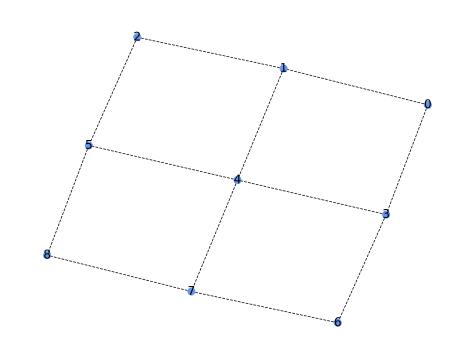

In [3]:
N=3

J_x  =  J_y  =  -0.5;              J_z = -1.0
h_x  =  1.0;      h_y = 0.0;       h_z = 0.5

model  =  getInstance( "Heisenberg", 
                       shape=(N,N), 
                       J=(J_x,J_y,J_z), 
                       h=(h_x,h_y,h_z), 
                       cell=SquareLattice )

model.draw_lattice()

The 1-norm of Hamiltonian coefficients $\alpha = \sum_i |\alpha_i| $ can be extracted from the instance object:

In [4]:
model.alpha

37.5

Next, we select a block encoding the Hamiltonian.  Our example will use a Select-Prepare based encoding called `PauliLCU`, which is suitable for Hamiltonians that can be expressed as a linear combination of unitary operators $H = \sum_i \alpha_i \Lambda_i$.  Each term in the Heisenberg Hamiltonian is a  Pauli string weighted by a real coefficient $\alpha_i$, which naturally satisfies this condition.  Although this encoding can be less efficient than other methods (since it explicitly handles every term in the Hamiltonian), it will accommodate most cases that arise in quantum simulation problems.

In [5]:
block_encoding    =  getEncoding(VALID_ENCODINGS.PauliLCU)(model)
t_count_encoding  =  estimate_resources(block_encoding)['T']
t_count_encoding

13432

The normalization factor for the `PauliLCU` encoding matches the 1-norm of the Hamiltonian:

In [6]:
alpha = block_encoding.alpha
alpha

37.5

The factor $\alpha$ is important since it effectively rescales the Hamiltonian.  In order to reproduce the correct physical dynamics under $\exp[\imath H t] = \exp[\imath (H/\alpha) (\alpha \cdot t)]$, we must rescale our time parameter $t \mapsto \alpha \cdot t$.  Having selected a model and encoding, we now generate our target time and phases.  We also specify a precision target `eps` for the angle generation procedure:

In [7]:
times       =  10.0 * N
eps         =  1e-3

phases      =  simulation_phases(times,eps=eps)

By default, this method will use an $R$-convention phase angle sequence for QET/QSVT.  Phases are returned as an array for sine and cosine terms (e.g., as`[cosine phases, sine phases]`):

In [8]:
[print(phase) for phase in phases]

Phase angles:		cos
Expression:		$f(x) = \cos [ tau \cdot x] / 2$
# of Phases:		49
Parameters:
			tau=30.0
Convention:		R
Phase Algorithm:	Optimization
Target Precision:	0.001
Optimizer:		Success
Angles Computed:	True

Phase angles:		sin
Expression:		$f(x) = \sin [ tau \cdot x] / 2$
# of Phases:		50
Parameters:
			tau=30.0
Convention:		R
Phase Algorithm:	Optimization
Target Precision:	0.001
Optimizer:		Success
Angles Computed:	True



[None, None]

Each of these terms is a container for phase angles:

In [9]:
print(phases[0].n_phases)
phases[0].phis

49


array([1.57079623, 1.5707971 , 1.57079083, 1.57083105, 1.57060361,
       1.57172369, 1.56699017, 1.58383123, 1.53471088, 1.64748874,
       1.45742317, 1.659739  , 1.59100437, 1.4782391 , 1.56527034,
       1.65339558, 1.61965879, 1.53752762, 1.49341241, 1.50203464,
       1.53715682, 1.57309552, 1.59857419, 1.61245174, 1.61672394,
       1.61245174, 1.59857419, 1.57309552, 1.53715682, 1.50203464,
       1.49341241, 1.53752762, 1.61965879, 1.65339558, 1.56527034,
       1.4782391 , 1.59100437, 1.659739  , 1.45742317, 1.64748874,
       1.53471088, 1.58383123, 1.56699017, 1.57172369, 1.57060361,
       1.57083105, 1.57079083, 1.5707971 , 1.57079623])

The `qsvt_dynamics()` method places most of `pyLIQTR`'s qubitized simulation capabilities under a single umbrealla $-$ from phase angle determination to circuit generation.  We will pass our phases to this method for now (and generate them automatically later):



In [10]:
gate_qsvt   =   qsvt_dynamics( encoding=getEncoding(VALID_ENCODINGS.PauliLCU),
                               instance=model,
                               phase_sets=phases )

---
#### LIQTR Like 👍 : Resource Analysis
---
Resource analysis of `cirq` circuits can be done by using the `pyLIQTR.utils.resource_analysis.estimate_resources` function, which will provide T, qubit, and Clifford counts for most circuits!

Note that our estimate for T-count is done via experimentally derived statistical distribution for the Clifford count of rotations at a given precision.

In [11]:
resource_estimate  =  estimate_resources(gate_qsvt)
print(resource_estimate)

{'LogicalQubits': 17, 'T': 1317449, 'Clifford': 2713385}


We can verify that this is dominated by the block encoding by noting that an $N$-phase sequence will contain $N-1$ repetitions of the block encoding (note: this value can occasionally be greater than one since  $T$-counting for rotation synthesis is done according to a statistical distribution by default):

In [12]:
(t_count_encoding * (phases[0].n_phases + phases[1].n_phases) - 2) / resource_estimate['T']

1.0093491285051641

Note that estimate resources has two keyword arguments that control $T$-synthesis.  The first is `rotation_gate_precision` (default `= 1e-10`), which specifies the maximum approximation error each rotation.  The second is `circuit_precision`, which overrides `rotation_gate_precision` if specified and sets the maximumum approximation error to `circuit_precision` / $N_\text{gates}$, where $N_\text{gates}$ is the number of rotation gates in a given circuit element.

---
#### LIQTR Like 👍 : Circuit Decomposition
---
`cirq` / `cirq-ft` provide the ability to decompose circuits/operators into their constituent parts (ie, a QSVT sequence is a cosine and then sine sequence). Different circuits will have different levels of decomposition, since they are composed of different operators. 

We generally think of a "level 0" decomposition as being the original circuit, a "level N-1" decomposition being a circuit level that includes non-clifford+T gates, and a "level N" decomposition as the level that consists of just the valid gate set for the architcture (ie clifford+T).

The following lines show supported levels of decompositions:

In [13]:
circuit_decompose_multi(gate_qsvt.circuit,1) 

control: ──────H───QSVT(cos)───QSVT(sin)───H───
                   │           │
phase: ────────────QSVT────────QSVT────────────
                   │           │
selection0: ───────QSVT────────QSVT────────────
                   │           │
selection1: ───────QSVT────────QSVT────────────
                   │           │
selection2: ───────QSVT────────QSVT────────────
                   │           │
selection3: ───────QSVT────────QSVT────────────
                   │           │
selection4: ───────QSVT────────QSVT────────────
                   │           │
selection5: ───────QSVT────────QSVT────────────
                   │           │
target0: ──────────QSVT────────QSVT────────────
                   │           │
target1: ──────────QSVT────────QSVT────────────
                   │           │
target2: ──────────QSVT────────QSVT────────────
                   │           │
target3: ──────────QSVT────────QSVT────────────
                   │           │
target4: ──────────QSVT────────QSVT────────────
                   │           │
target5: ──────────QSVT────────QSVT────────────
                   │           │
target6: ──────────QSVT────────QSVT────────────
                   │           │
target7: ──────────QSVT────────QSVT────────────
                   │           │
target8: ──────────QSVT────────QSVT────────────

Further decomposition reveals the iterative structure of this circuit:

In [14]:
circuit_decompose_multi(gate_qsvt.circuit,2) 

┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐                                   ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐
control: ──────H───Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.49π)─────PauliStringLCU────Rz(0.52π)─────PauliStringLCU────Rz(0.46π)─────PauliStringLCU────Rz(0.53π)─────PauliStringLCU────Rz(0.51π)─────PauliStringLCU────Rz(0.47π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.53π)─────PauliStringLCU────Rz(0.52π)─────PauliStringLCU────Rz(0.49π)─────PauliStringLCU────Rz(0.48π)─────PauliStringLCU────Rz(0.48π)─────PauliStringLCU────Rz(0.49π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.51π)─────PauliStringLCU────Rz(0.51π)─────PauliStringLCU────Rz(0.51π)─────PauliStringLCU────Rz(0.51π)─────PauliStringLCU────Rz(0.51π)─────PauliStringLCU────Rz(0.50

In [15]:
circuit_decompose_multi(gate_qsvt.circuit,3) 

control: ──────H───────@──────────────────────────────────@───────────────────────────────────────@──────────────────────────────────@───────────────────────────────────────@──────────────────────────────────@───────────────────────────────────────@──────────────────────────────────@───────────────────────────────────────@──────────────────────────────────@───────────────────────────────────────@──────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@────────────────────────────────────@───────────────────────────────────────@──────────────────────────────────@───────────────────────────────────────@──────────────────────────────────@───────────────────────────────────────@──────────────────────────────────@───────────────────────────────────────@──────────────────────────────────@───────────────────────────────────────@──────────────────────────────────@───────────────────────────────────────@──────────X───────────────@──────────X───────────────────────@───────────────X───────────────────────@──────────X───────────────────────@───────────────X───────────────────────@──────────X───────────────────────@───────────────X───────────────────────@──────────X───────────────────────@───────────────

Successive decompositions breaks down gates into simpler and simpler operations, though they also begin to introduce the "decompose_protocol" qubits, which are ancilla qubits used for the implementation of certain operators (note - this circuit is large and printing can be very slow).

In [16]:
#circuit_decompose_multi(gate_qsvt.circuit,4) 

Note that  `qsvt_dynamics`  can also calculate  phase factors "on the fly" if further access to them is not required.  Moreover, the keyword `random=` can be used to generate a circuit with random phase angles.  This saves considerable time for tasks like resource estimation, where the actual phases may be unnecessary.

In [17]:
gate_qsvt   =   qsvt_dynamics( encoding=getEncoding(VALID_ENCODINGS.PauliLCU),
                               instance=model,
                               phase_algorithm="random",
                               eps=eps,
                               times=times)

In [18]:
t_count = estimate_resources(gate_qsvt)['T']
'{0:.2E}'.format( t_count )

'4.30E+07'

The `qsvt_dynamics` function will also accept a series of times and return the corresponding  QET circuits:

In [19]:
t_min       =  0.5
t_max       =  2.0
dt          =  0.5

times       =  np.arange(t_min,t_max+dt,dt)
eps         =  1e-3

gate_qsvt   =   qsvt_dynamics( encoding=getEncoding(VALID_ENCODINGS.PauliLCU),
                               instance=model,
                               phase_algorithm="optimization",
                               eps=eps,
                               times=times)


<h4><b>4.2. QET/QSVT Simulation: Scaling Analysis </b></h4> 


Having developed a basic set of tools, we can demonstrate a resource assessment workflow for "utility-scale" Heisenberg model instances.  This process can be quite slow when explicitly calculating phases, so we defer to the `phase_algorithm="random"` method.

Our objective is to determine the overhead for simulations up to a time $t = 10 N$, where $N$ is the number of sites along an edge of a square, periodic Heisenberg lattice.  We will quantify this overhead as the problem size is increased beyond a (readily) tractable limit for classical methods ($N=20$).   We use the same parameters as above, but now treat a peridoic system.  This must be activated by using the keyword `pbcs=(True,True)` with the `PauliLCU` encoding.

<b>WARNING:</b> <i>The calculation block below can take roughly one hour to execute.  Precomputed outputs are provided after the block.</i>

In [20]:

# t_count         =   []
# logical_qubits  =   []

# problem_scale  = list([2**n for n in range(2,9)])
# problem_qubits = np.array(problem_scale)**2
# times          = 10.0*np.array(problem_scale)

# eps=1e-3

# for N,time in zip(problem_scale,times):

#     model  =  getInstance( "Heisenberg", shape=(N,N), pbcs=(True,True), J=(J_x,J_y,J_z), 
#                            h=(h_x,h_y,h_z), cell=SquareLattice, )
    
#     gate_qsvt              =   qsvt_dynamics( encoding=getEncoding(VALID_ENCODINGS.PauliLCU),
#                                instance=model,
#                                phase_algorithm="random",
#                                eps=eps,
#                                times=time)

#     estimate = estimate_resources( gate_qsvt )

#     t_count.append( estimate['T'] )
#     logical_qubits.append( estimate['LogicalQubits'] )


Pre-calculated reference values below:

In [21]:
problem_scale     = [4, 8, 16, 32, 64, 96, 128]
problem_qubits    = [16, 64, 256, 1024, 4096, 9216, 16384]
logical_qubits    = [25, 75, 269, 1039, 4113, 9235, 16403]
t_count           = [259094504, 8168555706, 263652542888, 8516840589974, 272515603368822, 3714593714998372, 8635636988775496 ]

Fit the dataset:

In [22]:
### Add fits with proper scaling count

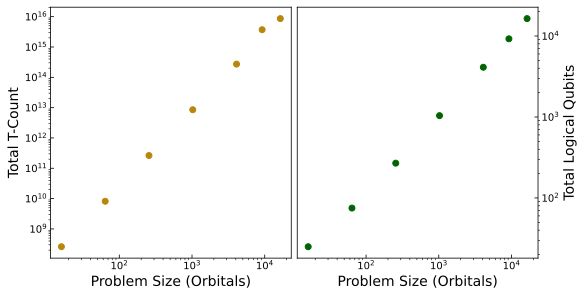

In [23]:
N_domain    =  np.linspace(problem_qubits[0],problem_qubits[-1], 100)

fig,ax = plt.subplots(1, 2, sharex=True,layout='constrained', figsize=(8, 4))

#ax[0].loglog(N_domain, fit_func_t_count(N_domain),linewidth=2,color='goldenrod')
ax[0].loglog(problem_qubits,t_count,'o',color='darkgoldenrod')
ax[0].tick_params(direction="in")
ax[0].set_xlabel('Problem Size (Orbitals)',fontsize=14);
ax[0].set_ylabel('Total T-Count',fontsize=14);

#ax[1].loglog(N_domain, fit_func_logical_qubits(N_domain),linewidth=2,color='darkseagreen')
ax[1].loglog(problem_qubits,logical_qubits,'o',color='darkgreen')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].tick_params(direction="in")
ax[1].set_xlabel('Problem Size (Orbitals)',fontsize=14);
ax[1].set_ylabel('Total Logical Qubits',fontsize=14);


---
#### LIQTR Like 👍 : Export of circuits to OpenQASM
---
Export of circuits can be done using a provided `pyLIQTR` utility (`pyLIQTR.utils.printing.openqasm`) that wraps `cirq`'s native openQASM export. This is introduced since some new cirq-ft operators do not yet have a decomposition in terms of gates defined, or `cirq` has begun to use features (mid-circuit measurement, classical control, etc) not supported by OpenQASM2.

This utility fully decomposes circuits to either include rotation gates (`rotation_allowed=True`) or not (`rotation_allowed=False`). 

In the latter case, we make use a of a Clifford+T representation outlined in https://arxiv.org/pdf/0806.3834.pdf (and further discussed in https://arxiv.org/pdf/1312.6584.pdf and http://www.cs.umd.edu/~amchilds/qa/qa.pdf, as potentially easier to digest forms).

When `rotation_allowed=False`, we introduce the "rx_d/ry_d/rz_d gate", followed by a line of the form:
```
// (leading_T, gate_sequence, sequence_length, clifford_part)
```
* `leading_T` : A bool indicating whether or not there is a `T` gate at the start of the sequence
* `gate_sequence`: An int whose binary representation encodes a sequence of `H`, `S`, and `T` gates
* `sequence_length`: The number of `T` gates in the sequence (note if `leading_T` is true, the total number of gates is `sequence_length+1`)
* `clifford_part`: A List[str] of clifford gates that come at the end of the H,S,T sequence.

Note that when `rotation_allowed=False`, you may also want to specify a level of precision by passing `gate_precision` or `circuit_precision` to `pyLIQTR.utils.printing.openqasm`

In [24]:
times = 1.0

gate_qsvt   =   qsvt_dynamics( encoding=getEncoding(VALID_ENCODINGS.PauliLCU),
                               instance=model,
                               phase_algorithm="optimization",
                               eps=eps,
                               times=times)

for ctr,line in enumerate(openqasm(gate_qsvt.circuit,rotation_allowed=False)):
    print(line)
    if ctr > 100:
        break

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [_ancilla_0, _ancilla_1, _ancilla_2, _ancilla_3, _ancilla_4, _ancilla_5, control, phase, selection0, selection1, selection2, selection3, selection4, selection5, target0, target1, target2, target3, target4, target5, target6, target7, target8]
qreg q[23];


sdg q[6];
h q[6];
rz_d(pi*0.5) q[6];
// (False, 0, 0, [S])
h q[6];
s q[6];
sdg q[7];
h q[7];
rz_d(pi*0.5) q[7];
// (False, 0, 0, [S])
h q[7];
s q[7];
sdg q[0];
h q[0];
rz_d(pi*0.5) q[0];
// (False, 0, 0, [S])
h q[0];
s q[0];
sdg q[1];
h q[1];
rz_d(pi*0.5) q[1];
// (False, 0, 0, [S])
h q[1];
s q[1];
sdg q[2];
h q[2];
rz_d(pi*0.5) q[2];
// (False, 0, 0, [S])
h q[2];
s q[2];
sdg q[3];
h q[3];
rz_d(pi*0.5) q[3];
// (False, 0, 0, [S])
h q[3];
s q[3];
sdg q[4];
h q[4];
rz_d(pi*0.5) q[4];
// (False, 0, 0, [S])
h q[4];
s q[4];
sdg q[5];
h q[5];
rz_d(pi*0.5) q[5];
// (False, 0, 0, [S])
h q[5];
s q[5];
rz_d(pi*1.5) q[14];
// (False, 0, 0, [(S**-1)])